In [21]:
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.sparse as scsp
import numpy as np
import os
import json
from ast import literal_eval

Make the paths match what you want to analyze and where to store the results

Currently analyzing every matrix in a folder will mean every file with matrix in its name, and the .mm or .bin extension depending on what you want

In [22]:
matrix_folder = "/home/tobias/opm/build_release/sim_results/24jan/23/verbose_norne_dump_matrices/reports/"
result_file_name = "norne_10_years"
amgcl_bin_to_mm_converter = "/home/tobias/Downloads/amgcl/build/examples/bin2mm"

BLOCKSIZE = 3 # the blocksize of the matrices in the folder
N_BLOCK_SPARSITY_PATTERNS = 2**(BLOCKSIZE*BLOCKSIZE)

MIN_RANK = 0
MAX_RANK = 5

# source can be json, bin, or mm
SOURCE = "mm"

analyze_matrix computes various characteristics of a bsr matrix and returns the results in a dictionary
Currently the function computes:
* Mean nonzero entries per row
* Median nonzero entries per row
* Min number of nonzero entries in a row
* max number of nonzero entries in a row
* whether or not the matrix is symmetric
* a bitmasked array showing the amount of blocks with each possible sparsity pattern

In [23]:
# these constants are used to index the resulting tuple from sio.mminfo
ROWS = 0
COLS = 1
ENTRIES = 2

def analyze_matrix(matrix, metadata):
    # compute a histogram of how many nonzero entries are in each row of the matrix
    M = len(matrix.indptr) - 1
    rowHistogram = np.zeros(M, dtype=int)
    for i in range(1, M+1):
        rowHistogram[i-1] = matrix.indptr[i]-matrix.indptr[i-1]

    # use the histogram to compute simple statistical characteristics of the matrix
    median = np.median(rowHistogram)
    min_nnz = np.min(rowHistogram)
    max_nnz = np.max(rowHistogram)
    arithmetic_mean = np.mean(rowHistogram)

    # check if the matrix is symmetric
    symmetric = True
    for row in range(M):
        for colIdx in range(matrix.indptr[row], matrix.indptr[row+1]):
            col = matrix.indices[colIdx]
            if row not in matrix.indices[matrix.indptr[col]:matrix.indptr[col+1]]:
                symmetric = False

    bit_masked_count = [0]*N_BLOCK_SPARSITY_PATTERNS
    for block_idx in range(len(matrix.data)):
        mask = 0
        mask += 1 if matrix.data[block_idx][0][0] != 0.0 else 0
        mask += 2 if matrix.data[block_idx][0][1] != 0.0 else 0
        mask += 4 if matrix.data[block_idx][1][0] != 0.0 else 0
        mask += 8 if matrix.data[block_idx][1][1] != 0.0 else 0
        bit_masked_count[mask] += 1

    return {
        "nnz" : str(metadata[ENTRIES]),
        "dims" : str([metadata[ROWS], metadata[COLS]]),
        "median" : str(median),
        "minNnzInRow" : str(min_nnz),
        "maxNnzInRow" : str(max_nnz),
        "mean" : str(arithmetic_mean),
        "symmetric" : str(symmetric),
        "blockSparsity" : str(bit_masked_count)
    }

Note that when making the plots, we assume that the filenames in sorted order corresponds with chronological order
The binary numbers above the plot show the sparsity pattern of the block. This is stored in a row wise order where a 1 indicates a nonzero number, while a 0 indicates a 0 value. The bit string 1001 will then represent a block on the form [[a, 0], [0, b]], a != 0 and b != 0

In [24]:
def plot(rank):
    string_rank = "{:02d}".format(rank)
    collected_data = json.load(open(f"{result_file_name}_rank_{string_rank}.json"))

    failed = 0
    succeeded = 0
    for key, value in collected_data.items():
        if len(value) == 1:
            failed += 1
        else:
            succeeded += 1

    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12), sharey=True)
    axes = axes.flatten()

    block_sparsity_data = [[] for i in range(N_BLOCK_SPARSITY_PATTERNS)]
    x_values = []

    cnt = 0
    for key in sorted(collected_data):
        # if the analysis failed, dont try to add data
        if len(collected_data[key]) == 1:
            continue
        else:
            # if the filename
            dot_cnt = 0
            for char in key:
                dot_cnt+=1 if char=='.' else 0
            if dot_cnt > 1:
                continue

        x_values.append(cnt)
        cnt += 1

        for i in range(N_BLOCK_SPARSITY_PATTERNS):
            # get the number of counter occurences of the ith sparsity block type
            string_form_of_list = collected_data[key]["blockSparsity"]
            list_form_of_string_of_list = literal_eval(string_form_of_list)
            num_of_occurences = list_form_of_string_of_list[i]

            # get the total number of blocks
            total_blocks = float(collected_data[key]["nnz"])/(BLOCKSIZE*BLOCKSIZE)

            # get the relative occurence to the total amount of nonzero blocks
            concentration = num_of_occurences / total_blocks

            block_sparsity_data[i].append(concentration)

    block_patterns = []
    for n in range(N_BLOCK_SPARSITY_PATTERNS):
        block_patterns.append([])

        for i in range(BLOCKSIZE):
            string = ""
            for j in range(BLOCKSIZE):
                string += "1" if (n & (1<<(i*BLOCKSIZE + j))) > 0 else "0"
            block_patterns[n].append(string)
        block_patterns[n] = ' '.join(block_patterns[n])

    for i in range(16):
        axes[i].plot(x_values, block_sparsity_data[i], label=f'Graph {i + 1}')
        axes[i].set_title(f'Pattern: {block_patterns[i]}')
        axes[i].legend()
        string_rank = "{:02d}".format(rank)
        plt.savefig(f"rank{string_rank}")

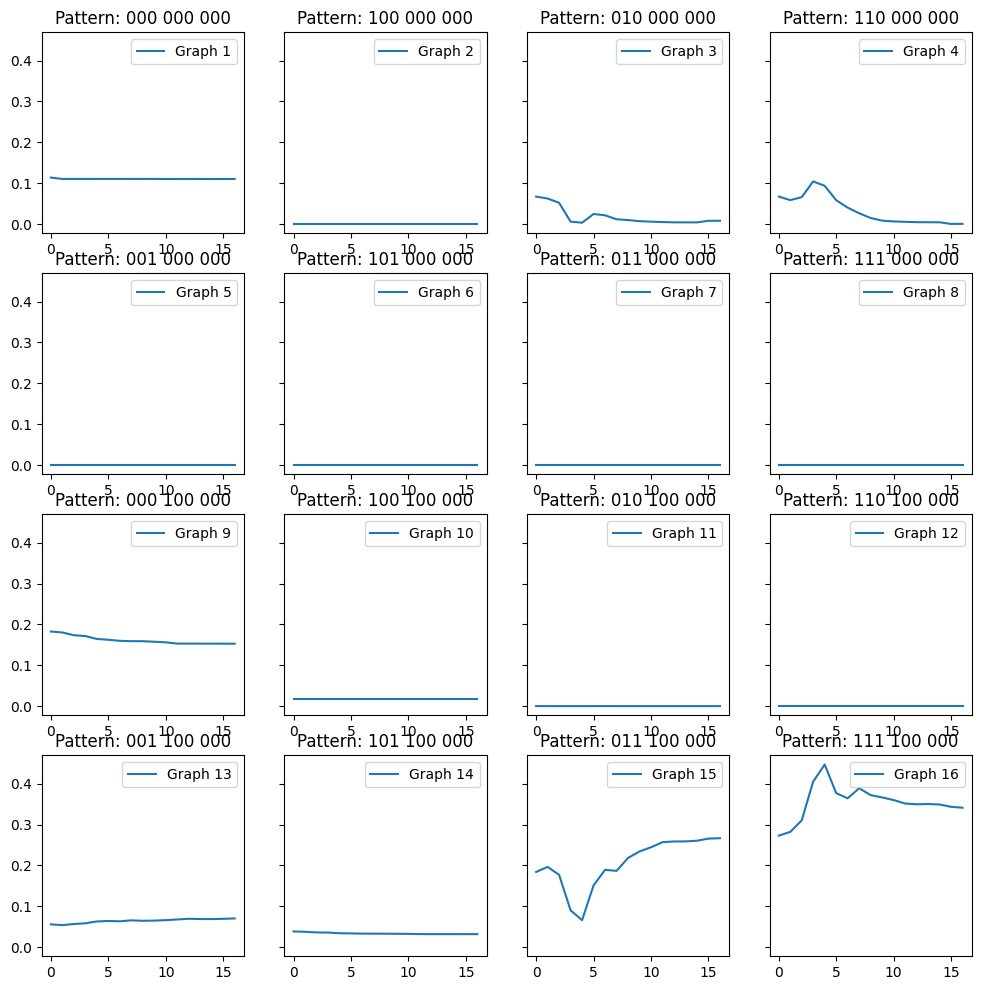

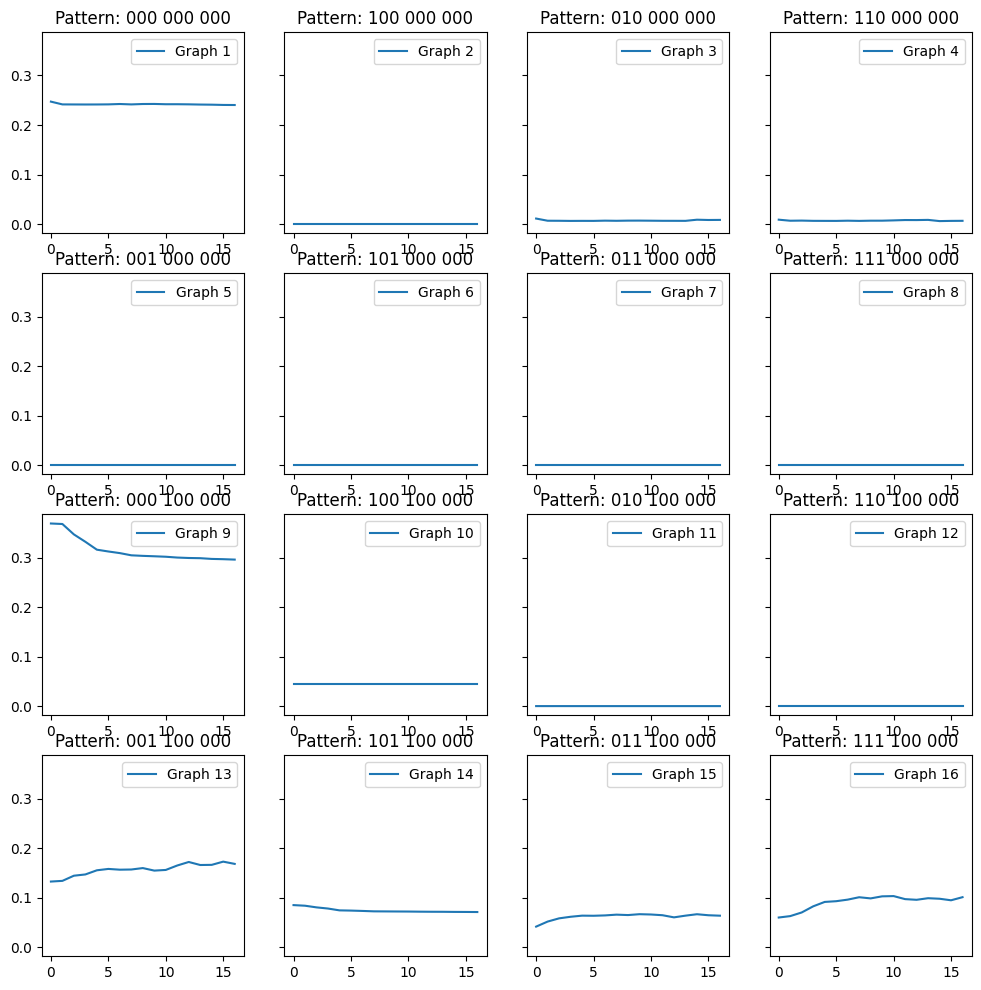

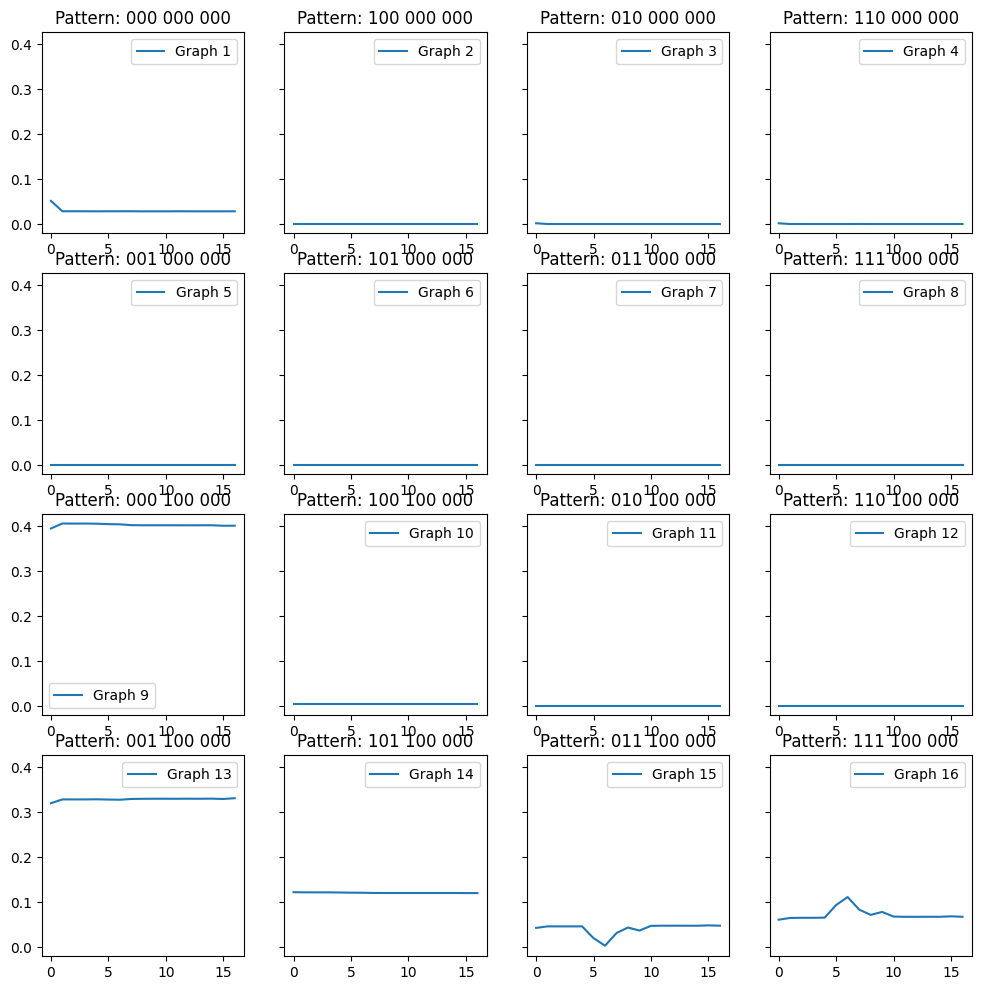

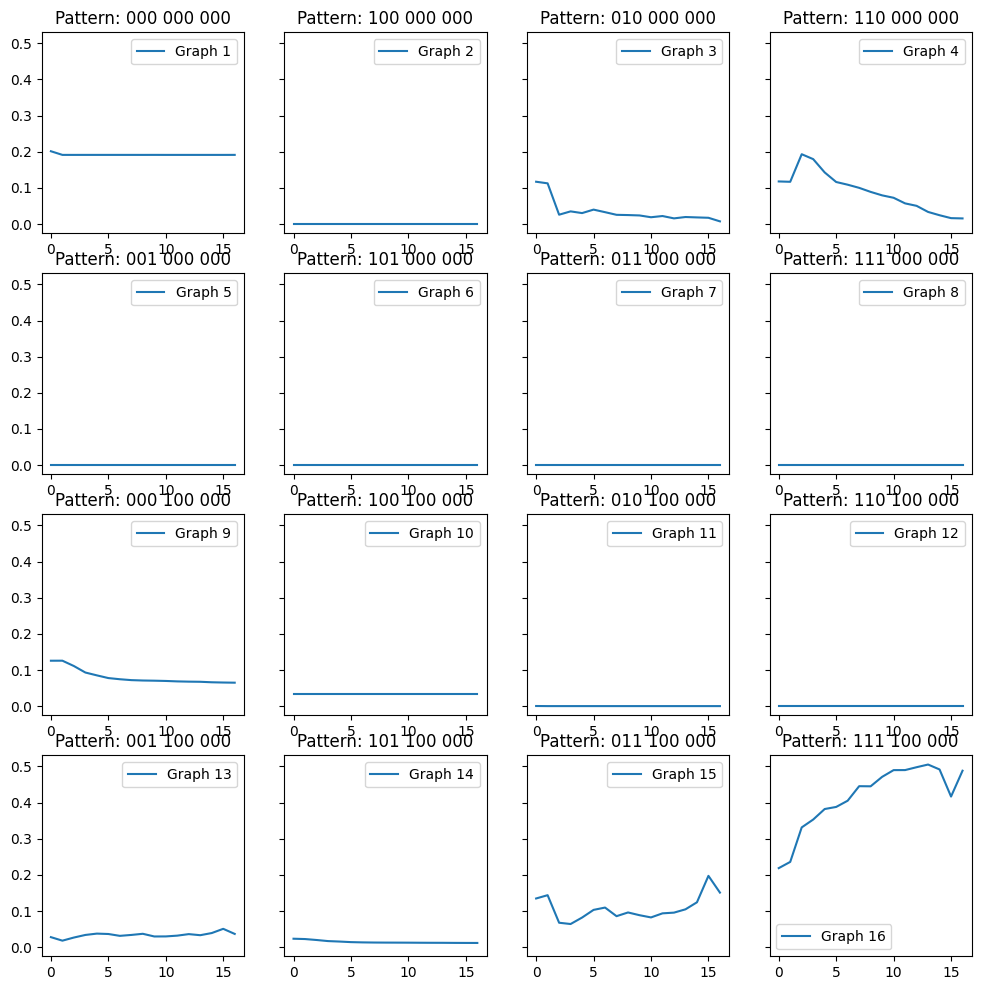

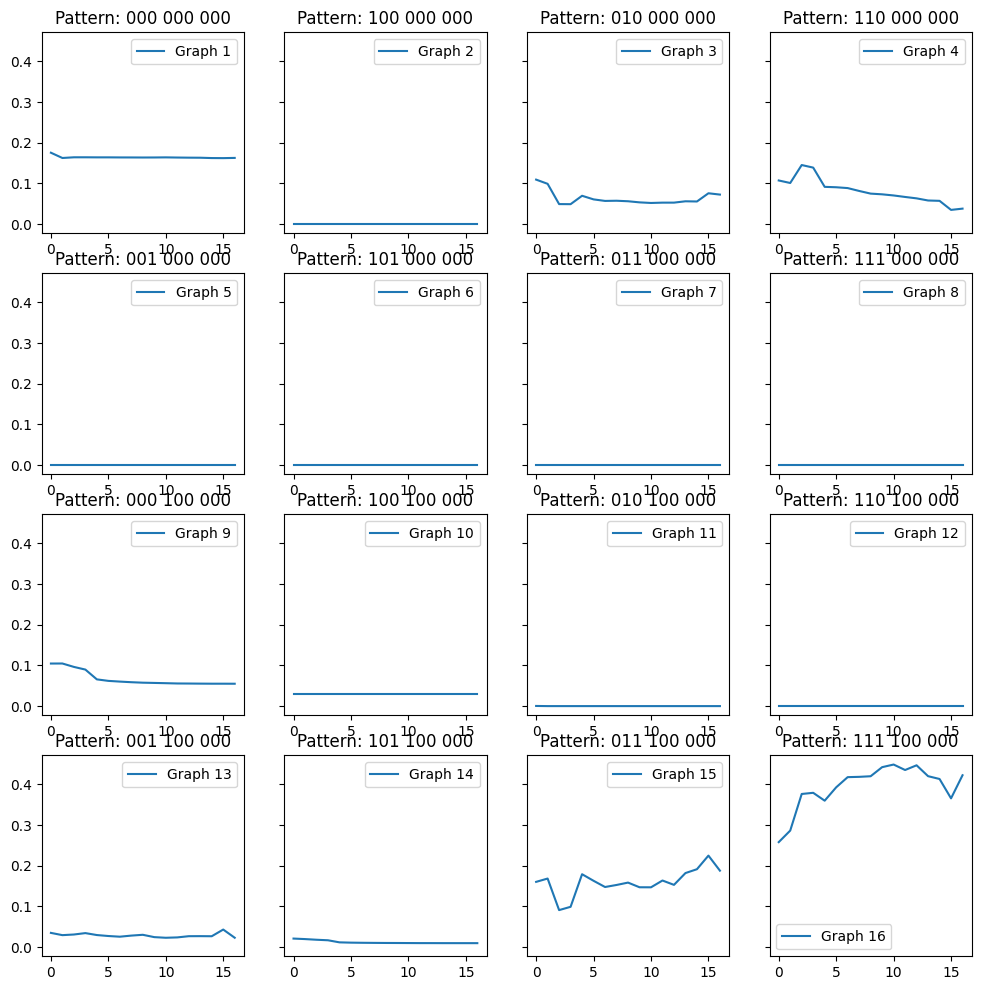

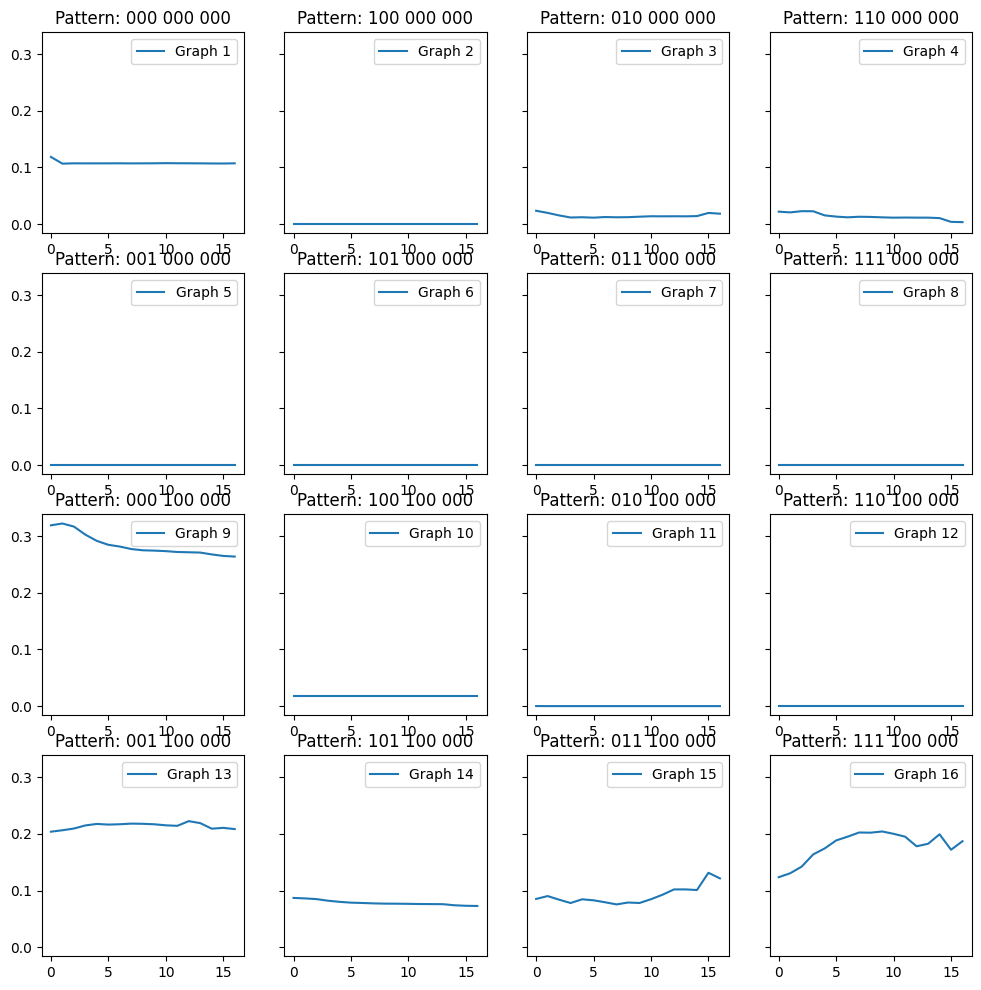

In [25]:
# this function returns true if the filename provided has "matrix" in it and the extension is the same as the one provided
def matrix_filter(filename, extension, rank):
    if f"matrix_istl_{rank}.mm" not in filename:
        return False
    if len(extension) > len(filename):
        return False
    if filename[len(filename) - len(extension):] != extension:
        return False
    return True

if SOURCE=="bin":
    pass
elif SOURCE=="mm":

    for rank in range(MIN_RANK, MAX_RANK+1):
        analysis_results = {}

        files = os.scandir(matrix_folder)
        filenames = []
        for f in files:
            filenames.append(f.name)
        filenames = list(filter(lambda e: matrix_filter(e, ".mm", rank), filenames))

        for matrix_file in filenames:
            # Read in the file as a BSR matrix
            path_to_matrix = matrix_folder + matrix_file
            try:
                matrix_metadata = sio.mminfo(path_to_matrix)
                matrix = sio.mmread(path_to_matrix)
                matrix = matrix.tobsr([BLOCKSIZE,BLOCKSIZE])

                analysis_results[matrix_file] = analyze_matrix(matrix, matrix_metadata)
                # print(matrix_file, " analyzed")
            except:
                analysis_results[matrix_file] = {"FAILED ANALYSIS" : "FAILED ANALYSIS"}
                print("analysis failed for", matrix_file)

        string_rank = "{:02d}".format(rank)

        with open(f"{result_file_name}_rank_{string_rank}.json", 'w', encoding='utf-8') as f:
            json.dump(analysis_results, f, ensure_ascii=False, indent=4)

        plot(rank)
elif SOURCE=="json":
    for rank in range(MIN_RANK, MAX_RANK+1):
        plot(rank)

In [31]:
BLOCKSIZE=2
matrixconv = sio.mmread("/home/tobias/opm/build_release/sim_results/24jan/23/verbose_sleipner_dump_matrices/reports/convertedmat.mm")
conv =  sio.mminfo("/home/tobias/opm/build_release/sim_results/24jan/23/verbose_sleipner_dump_matrices/reports/convertedmat.mm")
matrixconv = matrixconv.tobsr([BLOCKSIZE,BLOCKSIZE])

matrixcurr = sio.mmread("/home/tobias/opm/build_release/sim_results/24jan/23/verbose_sleipner_dump_matrices/reports/currentmat.mm")
curr = sio.mminfo("/home/tobias/opm/build_release/sim_results/24jan/23/verbose_sleipner_dump_matrices/reports/currentmat.mm")
matrixcurr = matrixcurr.tobsr([BLOCKSIZE,BLOCKSIZE])


In [32]:
print(f"{conv=}")
print(f"{curr=}")

conv=(326830, 326830, 4483316, 'coordinate', 'real', 'general')
curr=(326830, 326830, 4483316, 'coordinate', 'real', 'general')


In [38]:
print(np.all(matrixconv.data == matrixcurr.data))
print(f"{np.mean(matrixconv.data)=}")
print(f"{np.mean(matrixconv.data[matrixconv.data!=0.0])=}")
print(f"{np.median(matrixconv.data)=}")
print(f"{np.median(matrixconv.data[matrixconv.data!=0.0])=}")
print(f"{np.amax(matrixconv.data)=}")
print(f"{np.amin(matrixconv.data)=}")

True
np.mean(matrixconv.data)=0.030369157360367185
np.mean(matrixconv.data[matrixconv.data!=0.0])=0.09704403585716787
np.median(matrixconv.data)=0.0
np.median(matrixconv.data[matrixconv.data!=0.0])=-4.384266e-09
np.amax(matrixconv.data)=739.4448
np.amin(matrixconv.data)=-409.9898


(array([1.00000e+00, 1.00000e+00, 2.00000e+00, 0.00000e+00, 7.00000e+00,
        3.00000e+00, 3.00000e+00, 5.00000e+00, 5.00000e+00, 6.00000e+00,
        1.00000e+01, 1.20000e+01, 1.00000e+01, 9.00000e+00, 1.30000e+01,
        9.00000e+00, 2.00000e+01, 3.00000e+01, 2.90000e+01, 4.90000e+01,
        4.90000e+01, 1.80000e+01, 1.60000e+01, 1.40000e+01, 3.30000e+01,
        1.60000e+01, 4.20000e+01, 9.00000e+00, 6.00000e+00, 9.00000e+00,
        9.00000e+00, 7.00000e+00, 1.60000e+01, 1.00000e+01, 1.70000e+01,
        2.90000e+01, 3.30000e+01, 1.52000e+02, 6.53000e+02, 1.38432e+05,
        5.10000e+01, 8.60000e+01, 3.60000e+01, 3.40000e+01, 1.00000e+01,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.30000e+01, 7.30000e+01, 2.11000e+02, 3.73000e+02, 6.94000e+02,
        1.28000e+03, 7.91000e+02, 6.15000e+02, 4.82000e+02, 7.23000e+02,
        6.57000e+02, 8.58000e+02, 1.08700e+03, 2.01100e+03, 1.76700e+03,
        6.03000e+02, 2.45000e+02, 3.09000e+02, 1.69

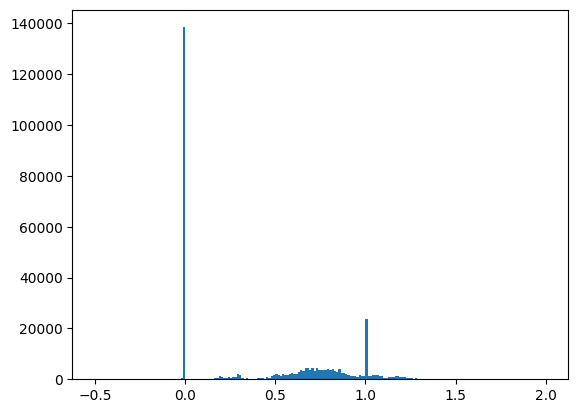

In [51]:
plt.hist(matrixconv.data[np.abs(matrixconv.data)>1e-3].flatten(), bins=200, range=(-0.5, 2))